#### 前言

本实验为使用AlexNet网络做猫狗分类任务；数据集为猫狗的图片，其中猫的图片12500张，狗的图片12500张；训练数据集猫12300张，狗12300张，验证集猫100张，狗100张，测试集猫100张，狗100张；数据集链接：https://pan.baidu.com/s/11UHodPIHRDwHiRoae_fqtQ 提取码：d0fa；实验经过了模型搭建，训练，测试以及结果分析。

#### 数据集分类

In [1]:
import os
import re
import shutil

In [2]:
origin_path = '/workspace/src/how-to-read-paper/dataset/train'
target_path_0 = '/workspace/src/how-to-read-paper/dataset/train_0/0'
target_path_1 = '/workspace/src/how-to-read-paper/dataset/train_0/1'

os.makedirs(target_path_0, exist_ok=True)
os.makedirs(target_path_1, exist_ok=True)

file_list = os.listdir(origin_path)

for i in range(len(file_list)):
    old_path = os.path.join(origin_path, file_list[i])
    result = re.findall(r'\w+', file_list[i])[0]
    if result == 'cat':
        shutil.move(old_path, target_path_0)
    else:
        shutil.move(old_path, target_path_1)

#### AlexNet部分

In [1]:
import torch
import os
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torch.utils.data
from PIL import Image
import torchvision.transforms as transforms

# 超参数设置
DEVICE = torch.device('cuda'if torch.cuda.is_available() else 'cpu')
EPOCH = 100
BATCH_SIZE = 256

#### 卷积层和全连接层、前向传播

In [2]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        # 卷积层
        self.features = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=11),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(48, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # 全连接层
        self.classifier = nn.Sequential(
            nn.Linear(6*6*128, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048, num_classes),
        )
    # 前向传播
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
    
        return x

#### 训练集、测试集、验证集的导入

In [3]:
# 归一化处理
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# 训练集
path_1 = '/workspace/src/how-to-read-paper/dataset/train_0'
trans_1 = transforms.Compose([
    transforms.Resize((65, 65)),
    transforms.ToTensor(),
    normalize,
])

# 数据集
train_set = ImageFolder(root=path_1, transform=trans_1)
# 数据加载器
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# 测试集
path_2 = '/workspace/src/how-to-read-paper/dataset/test'
trans_2 = transforms.Compose([
    transforms.Resize((65, 65)),
    transforms.ToTensor(),
    normalize,
])
test_data = ImageFolder(root=path_2, transform=trans_2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# 验证集
path_3 = '/workspace/src/how-to-read-paper/dataset/valid'
trans_3 = transforms.Compose([
    transforms.Resize((65, 65)),
    transforms.ToTensor(),
    normalize,
])
valid_data = ImageFolder(root=path_3, transform=trans_3)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

#### 训练

In [4]:
# 定义模型
model = AlexNet().to(DEVICE)
# 优化器的选择
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

In [5]:
def train_model(model, device, train_loader, optimizer, epoch):
    train_loss = 0
    model.train()
    for batch_index, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, label)
        loss.backward()
        optimizer.step()
        if batch_index % 300 == 0:
            train_loss = loss.item()
            print('Train Epoch:{}\ttrain loss:{:.6f}'.format(epoch, loss.item()))

    return train_loss

In [6]:
def test_model(model, device, test_loader):
    model.eval()
    correct = 0.0
    test_loss = 0.0

    # 不需要梯度的记录
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, label).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(label.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        print('Test_average_loss:{:.4f}, Accuracy:{:3f}\n'.format(test_loss, 100*correct/len(test_loader.dataset)))
        acc = 100*correct / len(test_loader.dataset)

    return test_loss, acc

#### 开始训练

In [7]:
list = []
Train_Loss_list = []
Valid_Loss_list = []
Valid_Accuracy_list = []

for epoch in range(1, EPOCH+1):
    # 训练集训练
    train_loss = train_model(model, DEVICE, train_loader, optimizer, epoch)
    Train_Loss_list.append(train_loss)
    torch.save(model, r'/workspace/src/how-to-read-paper/model/model%s.pth' % epoch)

    # 验证集进行验证
    test_loss, acc = test_model(model, DEVICE, valid_loader)
    Valid_Loss_list.append(test_loss)
    Valid_Accuracy_list.append(acc)
    list.append(test_loss)

Train Epoch:1	train loss:0.693288
Test_average_loss:0.0035, Accuracy:58.000000

Train Epoch:2	train loss:0.691788
Test_average_loss:0.0035, Accuracy:50.000000

Train Epoch:3	train loss:0.689242
Test_average_loss:0.0033, Accuracy:59.000000

Train Epoch:4	train loss:0.673659
Test_average_loss:0.0032, Accuracy:65.500000

Train Epoch:5	train loss:0.661889
Test_average_loss:0.0031, Accuracy:63.000000

Train Epoch:6	train loss:0.665716
Test_average_loss:0.0026, Accuracy:71.500000

Train Epoch:7	train loss:0.563154
Test_average_loss:0.0027, Accuracy:71.500000

Train Epoch:8	train loss:0.576363
Test_average_loss:0.0028, Accuracy:71.000000

Train Epoch:9	train loss:0.604858
Test_average_loss:0.0023, Accuracy:77.000000

Train Epoch:10	train loss:0.534222
Test_average_loss:0.0020, Accuracy:82.500000

Train Epoch:11	train loss:0.507165
Test_average_loss:0.0019, Accuracy:81.500000

Train Epoch:12	train loss:0.452637
Test_average_loss:0.0022, Accuracy:81.000000

Train Epoch:13	train loss:0.421578
Te

#### 测试

In [8]:
# 验证集的test_loss

min_num = min(list)
min_index = list.index(min_num)

print('model%s' % (min_index+1))
print('验证集最高准确率：')
print('{}'.format(Valid_Accuracy_list[min_index]))

# 取最好的进入测试集进行测试
model = torch.load('/workspace/src/how-to-read-paper/model/model%s.pth' % (min_index+1))
model.eval()

accuracy = test_model(model, DEVICE, test_loader)
print('测试集准确率')
print('{}%'.format(accuracy))

model37
验证率最高准确率：
93.5
Test_average_loss:0.0020, Accuracy:91.500000

测试集准确率
(0.0020330829918384554, 91.5)%


#### 绘图

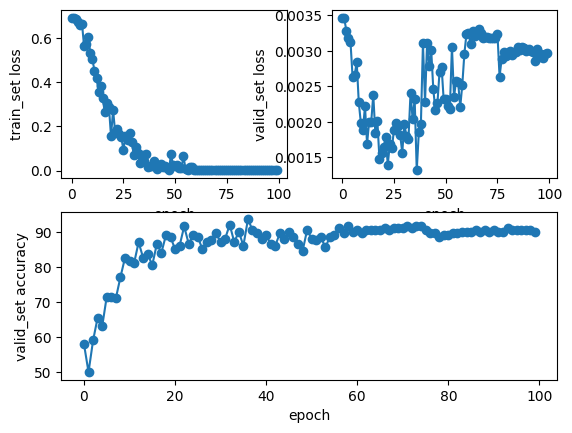

In [9]:
# 坐标轴变量含义
x1 = range(0, EPOCH)
y1 = Train_Loss_list
y2 = Valid_Loss_list
y3 = Valid_Accuracy_list

# 图表位置
plt.subplot(221)
# 线条
plt.plot(x1, y1, '-o')
# 坐标轴标注
plt.ylabel('train_set loss')
plt.xlabel('epoch')

plt.subplot(222)
plt.plot(x1,y2,'-o')
plt.ylabel('valid_set loss')
plt.xlabel('epoch')
 
plt.subplot(212)
plt.plot(x1,y3,'-o')
plt.ylabel('valid_set accuracy')
plt.xlabel('epoch')
 
#显示
plt.show()